## Objetivo
A partir de um sinal de vibração genérico: 

    1. Visualizar o sinal no tempo, seus parâmetros estatísticos e histograma. 
    2. Visualizar o sinal na frequênica, identificando os picos dominantes.
    3. Testar os métodos de extração de características.
    
Abaixo é feita a importação das bibliotecas e a leitura de um aquivo genérico.

In [1]:
# bibliotecas mais importantes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy.signal as signal

# tema padrão do seaborn
sns.set_theme()

In [2]:
def read_file(address, ratio):
    # poupa apenas as linhas múltiplas de 'ratio' e lista as demais para exclusão
    skip=[i for i in range(0,250000) if i%ratio] 

    # lê dados no tempo
    signals = pd.read_csv(
        '../mafaulda/imbalance/35g/56.7296.csv', 
        header=None, 
        names=['tacometro','ax1','rad1','tg1','ax2','rad2','tg2','microfone'],
        skiprows=skip,
    )

    # reordena colunas
    return signals[['tacometro','microfone','ax1','ax2','rad1','rad2','tg1','tg2']]


def fft_transform(signals_df, sampling_freq):
    # aplica transformada de Fourrier, converte para valores absolutos 
    signals_fft = signals_df.apply(np.fft.rfft, axis=0, norm="ortho")
    signals_fft = signals_fft.apply(np.abs)

    # adiciona eixo da frequência
    # OBS: a frequência de Nyquist é sampling_freq/2
    signals_fft['freq_ax'] = np.linspace(0, sampling_freq/2, signals_fft.shape[0])
    
    return signals_fft
    
    
# reduz o a frequência de amostragem 'ratio' vezes, tomando apenas 1 a cada 'ratio' sinais
ratio = 50
sampling_freq=50000/ratio

#signals = read_file('../mafaulda/imbalance/35g/56.7296.csv', ratio=ratio)
signals = read_file('../mafaulda/vertical-misalignment/1.90mm/61.44.csv', ratio=ratio)
accelerations = signals.drop(['tacometro','microfone'], axis=1)

signals_fft = fft_transform(signals, sampling_freq=sampling_freq)
accelerations_fft = signals_fft.drop(['tacometro', 'microfone'], axis=1)

print("\nSinal com shape {}".format(signals.shape))
print("a frequência de aquisição foi reduzida de 50kHz para {}kHz\n".format(sampling_freq/1000))
# signals.head()


Sinal com shape (5000, 8)
a frequência de aquisição foi reduzida de 50kHz para 1.0kHz



# Análise no tempo
É interessante comparar a amplitude de cada sinal e a visualização deles no tempo.

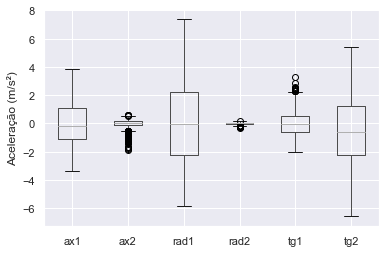

In [3]:
# checa nível dos sinais de aceleração
accelerations.boxplot()
plt.ylabel('Aceleração (m/s²)')
plt.show()

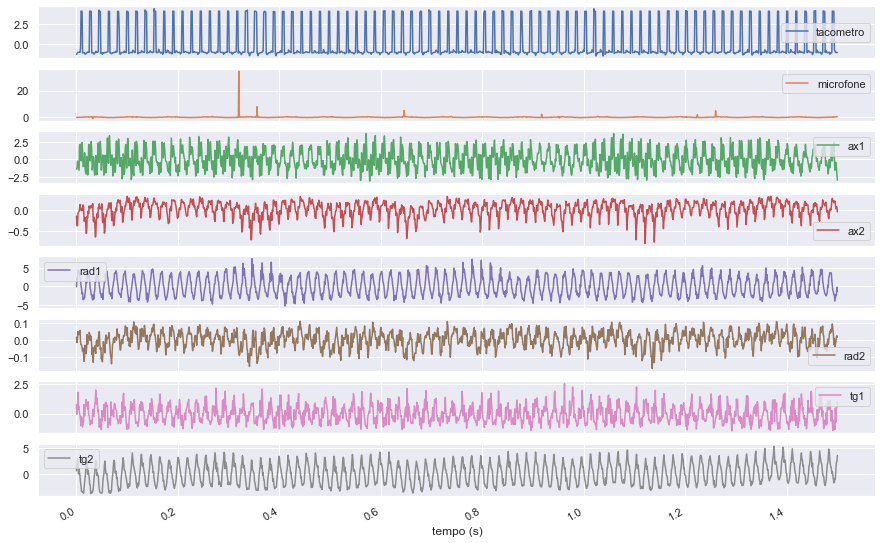

In [4]:
signals['tempo (s)'] = np.linspace(0, 5, signals.shape[0])
signals.loc[:1500].plot(subplots=True, x='tempo (s)', layout=(8,1), figsize=(15,10))
signals.pop('tempo (s)');

Como curiosidade, pode-se também escutar o som gerado pelo microfone.

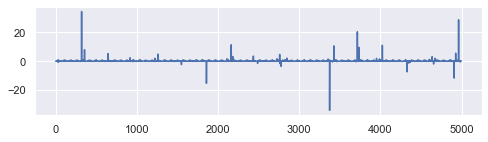

Som do microfone


In [6]:
# detalha sinal do microfone no tempo
signals['microfone'].plot(figsize=(8,2))
plt.show()

from IPython.display import Audio, display
print('Som do microfone')
display(Audio(signals['microfone'], rate=sampling_freq))

# Extração de parâmetros

Uma referencia para técnicas de extração de características: http://mkalikatzarakis.eu/wp-content/uploads/2018/12/IMS_dset.html

## Domínio do tempo

São sugeridos alguns parâmetros. Em destaque, aqueles que já foram implementados:

 - Statistical moments: 
  - **mean**, 
  - standard deviation, 
  - skewness, 
  - **kurtosis**
 - **Shannon entropy**, smoothness and uniformity
 - **Root-mean-squared**, absolute, and peak-to-peak value of the waveform
 - Shape, crest, impulse and margin factors
 
Abaixo o histograma dos sinais e em seguida os métodos de extração.

,ax1,ax2,rad1,rad2,tg1,tg2
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.009060,-0.015132,0.018881,-0.001533,0.000511,-0.491108
std,1.461958,0.252495,2.520013,0.059690,0.747373,2.232732
min,-3.347600,-1.900500,-5.826600,-0.291740,-2.002700,-6.566900
50%,-0.178630,0.029198,-0.050837,0.004369,-0.064949,-0.584650
max,3.882100,0.580670,7.402600,0.163360,3.306800,5.408800


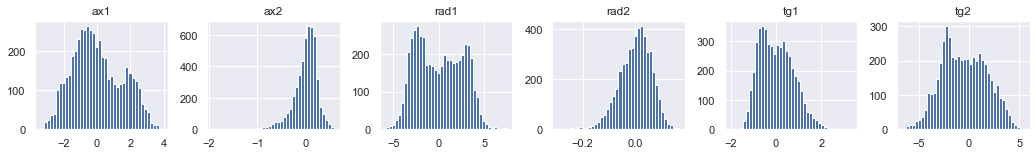

In [7]:
# histograma para cada sinal
accelerations.hist(bins=40, figsize=(24,2), layout=(1,8))
accelerations.describe(percentiles=[])

In [8]:
def calc_entropy(dataframe):
    entropias = {}
    
    for col in dataframe.columns.values[:]:
        # divide cada sinal em 100 faixas e faz a contagem para cada faixa
        out = np.histogram(dataframe[col], bins=100)[0]
        # calcula a entropia de shannon
        entropias[col] = stats.entropy(out)
        
    return entropias

# Média
medias = accelerations.mean().to_dict()
medias = {k+'_mean': v for k,v in medias.items()}

# Curtose
curtoses = accelerations.kurtosis().to_dict()
curtoses = {k+'_kurt':v for k, v in curtoses.items()}

# RMS
rms = accelerations.pow(2).sum().pow(1/2).to_dict()
rms = {k+'_rms':v for k, v in rms.items()}

# Entropia
entropias = calc_entropy(accelerations)
entropias = {k+'_entropy':v for k,v in entropias.items()}

# Combinação dos dados
time_statistics = entropias
time_statistics.update(medias)
time_statistics.update(curtoses)
time_statistics.update(rms)

## Domínio da frequência
Para a estimar a densidade espectral e demais parâmetros no domínio da frequência, outros métodos são sugeridos. Novamente, aqueles implementados são destacados.
 - Autoregressive coefficients
 - Frequency domain features (through an FFT transformation):
 - **Vibration levels at characteristic frequencies** of the machine
 - Frequency center
 - Mean square and root-mean-square frequency
 - Variance and root-variance of frequency
 - Spectral skewness, kurtosis, entropy
 - Similar features in higher order spectra

## Fundamental
A primeira frequência de interesse é a de rotação do eixo. Ela é obtida a partir do espectro do tacômetro.

In [9]:
def extract_fundamental(fft_df):
    tachometer_fft = fft_df['tacometro'].copy(deep=True)
    candidates = [0, 0, 0]
    
    # separa os 3 maiores picos na fft do tacômetro
    for i in range(3):
        index = tachometer_fft.argmax()
        candidates[i] = fft_df.freq_ax[index]
        
        # retira da próxima iteração os valores adjacentes ao pico separado
        for j in range(-2, 3):
            tachometer_fft[index+j] = 0
    
    # deve retornar pico o de menor frequência, evitando o mascaramento da fundamental pelas harmonicas
    fundamental = min(candidates)
    index = fft_df.index[fft_df['freq_ax'] == fundamental]
    
    return fundamental, index[0]


fundamental, index = extract_fundamental(signals_fft)
print("Fundamental de {:0.2f} Hz, no índice {}".format(fundamental, index))

Fundamental de 55.40 Hz, no índice 277


## Hamônicas

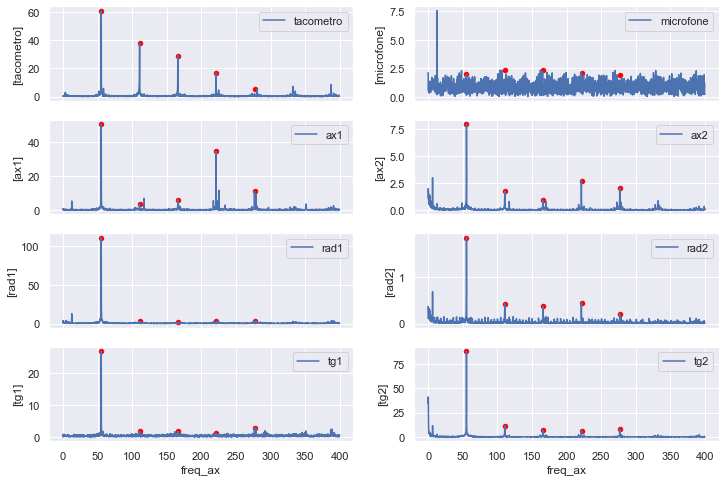

In [19]:
idx = index
harmonic_values = pd.DataFrame(columns = signals_fft.columns)

for i in range(1,6):
    # resgata no DataFrame os valores na harmonica i, o máximo em um intervalo de pontos adjacentes
    harmonic_values = harmonic_values.append(signals_fft.iloc[idx*i-25:idx*i+26].max(), ignore_index=True)
    # salva as frequências hamônicas, para plotar pontos no gráfico
    harmonic_values.iloc[-1]['freq_ax'] = fundamental*i


# gera os plots
fig, axes = plt.subplots(4,2,figsize=(12, 8),sharex=True)
for i, col in enumerate(signals_fft.columns.values[:-1]):
    signals_fft[:2000].plot(x='freq_ax', y=[col], ax=axes[i//2,i%2])
    harmonic_values.plot(x='freq_ax', y=[col], ax=axes[i//2,i%2], kind='scatter', color="red")
    
plt.show()

In [11]:
# função implementada na extração de dados

def extract_n_harmonics(fft_df, idx, n_harmonics=3):
    # extrai todos os valores nos n primeiros harmônicos, exceto para o tacometro e freq_ax
    fft_df = fft_df.drop(['tacometro', 'freq_ax', 'microfone'], axis=1)

    harmonic_features = {}
    for i in range(1, n_harmonics+1):
        # resgata no DataFrame os valores na harmonica i
        harm_values = fft_df.iloc[idx*i-25:idx*i+26].max()
        harm_values = harm_values.to_dict()
        
        # adiciona às features com o respectivo sulfixo do harmonico i
        harmonic_features.update({k+'_{}h'.format(i): v for k, v in harm_values.items()})

    return harmonic_features

harmonics = extract_n_harmonics(signals_fft, index, 4)

for k,v in harmonics.items():
    print('{:7} {:6.1f}'.format(k, v))

ax1_1h    50.7
ax2_1h     8.0
rad1_1h  110.8
rad2_1h    1.8
tg1_1h    26.8
tg2_1h    88.2
ax1_2h     3.6
ax2_2h     1.8
rad1_2h    3.0
rad2_2h    0.4
tg1_2h     1.8
tg2_2h    11.5
ax1_3h     6.0
ax2_3h     0.9
rad1_3h    1.6
rad2_3h    0.4
tg1_3h     1.8
tg2_3h     7.1
ax1_4h    34.7
ax2_4h     2.7
rad1_4h    3.4
rad2_4h    0.4
tg1_4h     1.2
tg2_4h     6.5


# Experimentos

## Alternativas ao FFT na análise do espectro

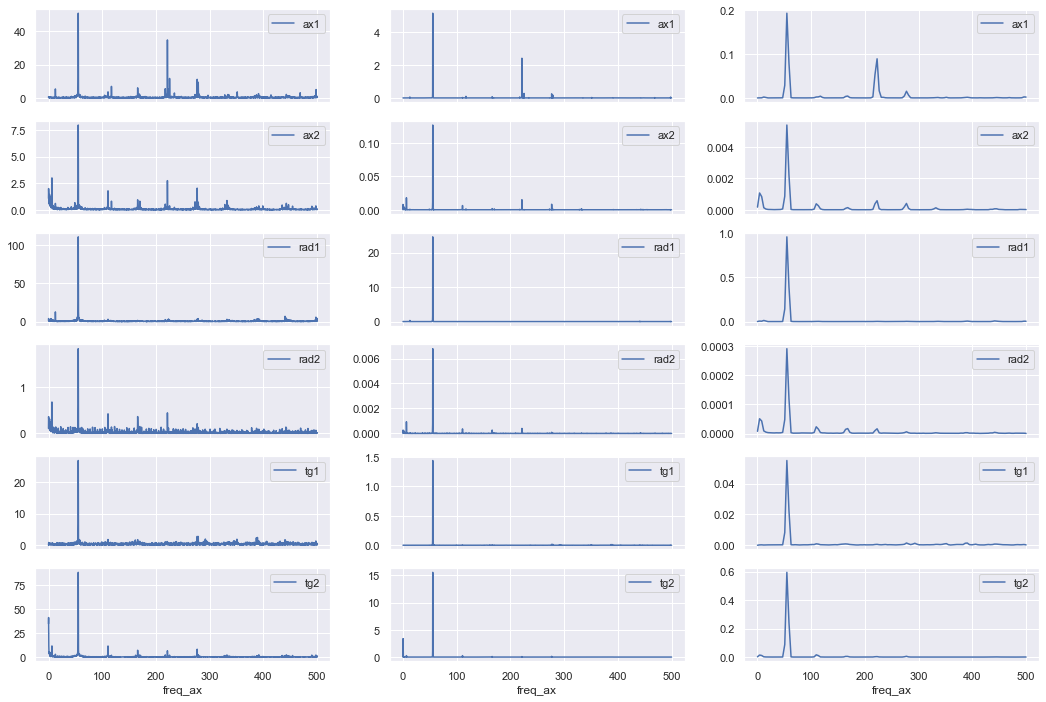

In [23]:
def generate_periodgram(accelerations, sampling_freq):
    periodgrams = pd.DataFrame(columns = accelerations.columns)

    for col in periodgrams.columns.values:
        f, Pxx = signal.periodogram(accelerations[col], fs=sampling_freq)
        periodgrams[col] = Pxx

    periodgrams['freq_ax'] = f
    
    return periodgrams

def generate_welch_periodgram(accelerations, sampling_freq):
    periodgrams = pd.DataFrame(columns = accelerations.columns)

    for col in periodgrams.columns.values:
        f, Pxx = signal.welch(accelerations[col], fs=sampling_freq)
        periodgrams[col] = Pxx

    periodgrams['freq_ax'] = f
    
    return periodgrams

periodgrams = generate_periodgram(accelerations, sampling_freq)
welch = generate_welch_periodgram(accelerations, sampling_freq)

fig, axes = plt.subplots(6,3,figsize=(18, 12),sharex=True)

for i, col in enumerate(accelerations_fft.columns.values[:-1]):
    accelerations_fft.plot(x='freq_ax', y=[col], ax=axes[i, 0])
    periodgrams.plot(x='freq_ax', y=[col], ax=axes[i, 1])
    welch.plot(x='freq_ax', y=[col], ax=axes[i, 2])

## Análise das velocidades
Componentes de 'corrente contínua', de frequência igual a zero, no sinal da aceleração idicariam que o aquipamento do ensaio possui uma aceleração líquida não nula em uma dada direção. No entanto, o ensaio foi feito sobre báse estática e portanto essa aceleração não é válida e deve ser ignorada.

O sinal de aceleração pode ser integrado para obtenção da velocidade no mesmo eixo. Esta interação, no entanto, acaba exacerbando componentes de baixa frequência. Para evitar a dominação se componentes espúrios de baixa frequência, propõe-se a aplicação de um filtro passa alta depois (ou antes) da integração.

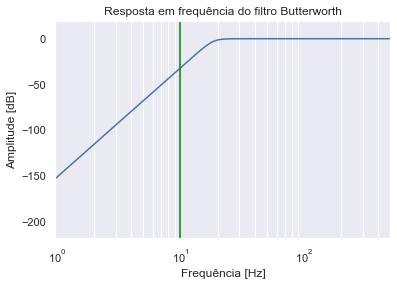

In [13]:
# ilustração do filtro passa alta
from scipy import signal

# define um filtro passa alta arbitrário em 1/3 da fundamental 
b, a = signal.butter(6, fundamental/3, 'highpass', fs=sampling_freq)
w, h = signal.freqz(b, a, fs=sampling_freq)
plt.semilogx(w, 20 * np.log10(abs(h)))

plt.title('Resposta em frequência do filtro Butterworth')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(10, color='green') # cutoff frequency
plt.show()

In [14]:
from scipy import integrate

# transforna-se o sinal de g para m/s²
accelerations_mmps2 = accelerations*9.80665*1000

# instancia o filtro passa alta
sos = signal.butter(6, 10, 'highpass', fs=sampling_freq, output='sos')

# calcula velocidade pela integral (trapezoidal) dos sinais
velocity_no_filter     = pd.DataFrame()
velocity_filter_before = pd.DataFrame()
filtered_acc           = pd.DataFrame()
velocity_filter_after  = pd.DataFrame()


dt = 1/sampling_freq
for col in accelerations_mmps2.columns:
    velocity_no_filter[col] = integrate.cumtrapz(y=np.array(accelerations_mmps2[col]), dx=dt, initial=0)
    correcao = velocity_no_filter[col].mean()
    velocity_no_filter[col] = velocity_no_filter[col].apply(lambda x: x - correcao)
    
    filtered_acc[col] = signal.sosfilt(sos, accelerations_mmps2[col])
    velocity_filter_before[col] =  integrate.cumtrapz(y=np.array(filtered_acc[col]), dx=dt, initial=0)

    velocity_filter_after[col] = integrate.cumtrapz(y=np.array(accelerations_mmps2[col]), dx=dt, initial=0)
    velocity_filter_after[col] = signal.sosfilt(sos, velocity_filter_after[col])


Nota-se que o sinal não filtrado teve os componentes de baixa frequencia amplificados pela integração.

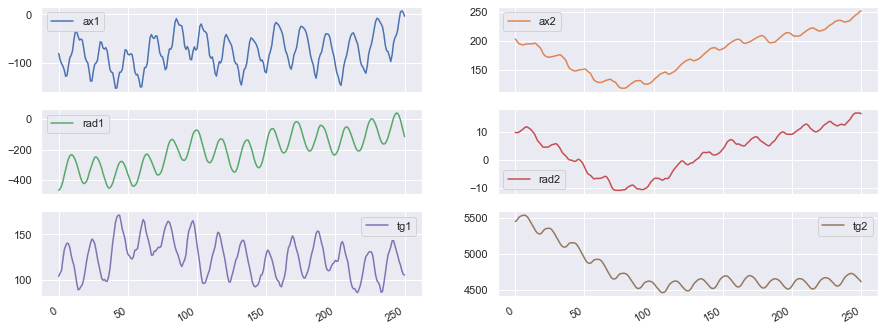

In [15]:
# velocidade NÃO FILTRADA no tempo 
velocity_no_filter.loc[:250].plot(subplots=True, layout=(4,2), figsize=(15,8));

Entre os sinais filtrados faz pouca diferença aplicar o filtro antes ou depois de integrar.

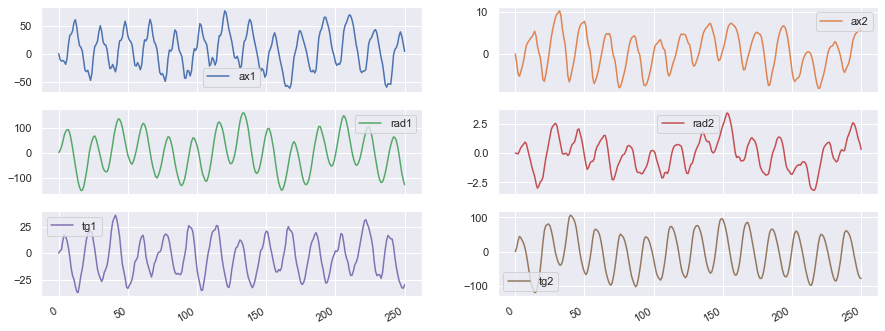

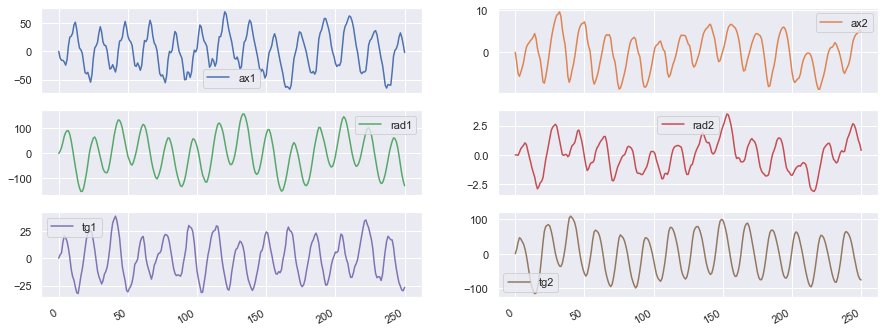

In [16]:
# velocidades FILTRADAS no tempo 
velocity_filter_before.loc[:250].plot(subplots=True, layout=(4,2), figsize=(15,8));
velocity_filter_after.loc[:250].plot(subplots=True, layout=(4,2), figsize=(15,8));

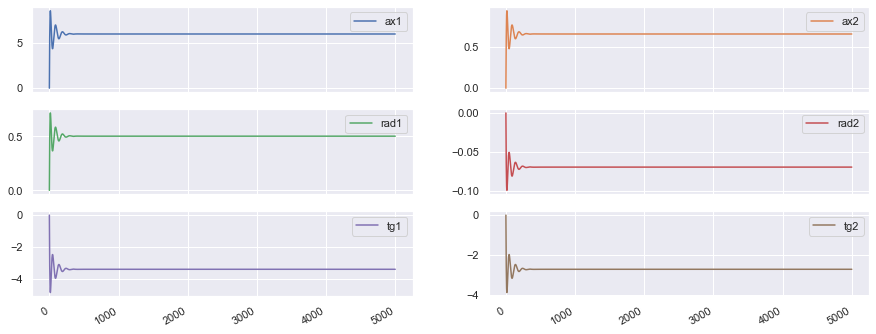

In [17]:
# diferença entre filtrar antes ou depois
velocity_filter_difference = velocity_filter_before - velocity_filter_after
velocity_filter_difference.plot(subplots=True, layout=(4,2), figsize=(15,8));

Note o offset em relação ao zero.

Há pouca diferença filtrar o sinal antes ou depois, EXCETO que filtrar depois garante a retirada de qualquer nível DC no sinal de velocidade. Verifique no espectro que não há nível DC.

In [192]:
# aplica a transformada no sinal filtrado                                     
velocity_fft = velocity_filter_after.apply(np.fft.rfft, axis=0, norm="ortho")
velocity_fft = velocity_fft.apply(np.abs)
velocity_fft['freq_ax'] = np.linspace(0, sampling_freq/2+1, signals_fft.shape[0])

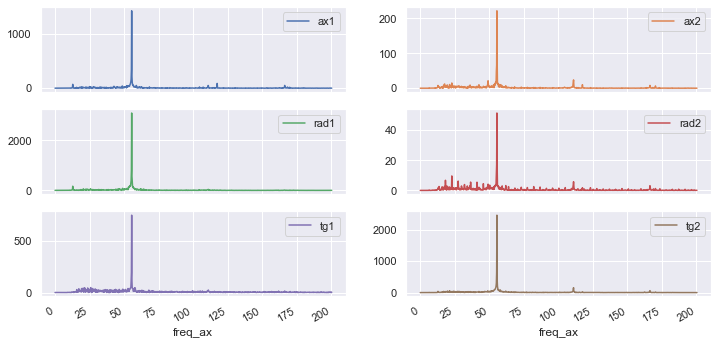

In [193]:
# velocidades na frequência
velocity_fft.loc[:1000].plot(subplots=True, x='freq_ax', layout=(4,2), figsize=(12,8))
plt.show()

Velocidade              ax1         ax2         rad1       rad2         tg1          tg2
277  1414.596659  221.984278  3088.871434  51.378489  748.434153  2460.716131

Aceleração            ax1       ax2        rad1      rad2        tg1        tg2
277  50.712762  7.959187  110.766036  1.842229  26.833181  88.222671

Plotando dados normalizados pelo maior valor em seu tipo de grandeza:


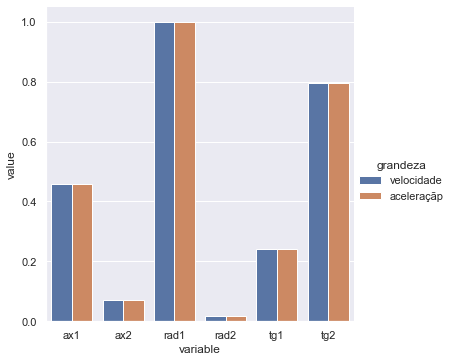

In [194]:
# faz tabulação dos valores de velocidade
vel = velocity_fft.iloc[index].drop('freq_ax', axis=1)
print('Velocidade', vel)
vel = vel/vel.max().max()
vel = vel.melt()
vel['grandeza'] = 'velocida

acc = accelerations_fft.iloc[index].drop('freq_ax', axis=1)
print('\nAceleração', acc)
acc = acc/acc.max().max()
acc = acc.melt()
acc['grandeza'] = 'aceleraçãp'

print('\nPlotando dados normalizados pelo maior valor em seu tipo de grandeza:')
sns.catplot(data=pd.concat([vel,acc]), kind='bar', x='variable', y='value', hue='grandeza');

Nota-se que os valores de pico na velocidade e na aceleração apresentam a mesma relação de grandeza entre si.

No entanto, analisando os valores RSM há pequenas variações, possivelmente devido ao filtro passa alta.

RMS velocidades: [31.076431176012854, 5.331500391682059, 67.80689479597717, 1.3115465604547722, 17.252524216363085, 53.60999937070239]
RMS acelerações: [1.4618395567370515, 0.25292235038401206, 2.519832083744101, 0.05970329752621397, 0.7472983198833273, 2.2858880240787958]
Valores de RMS:


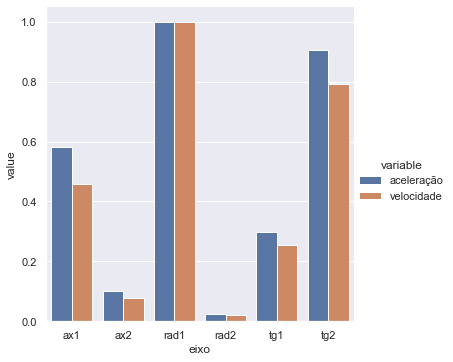

In [195]:
def rms(x):
    return np.sqrt(x.dot(x)/x.size)

rms_vel = []
for col in velocity_filter_after.columns:
    rms_vel.append( rms(np.array(velocity_filter_after[col])) )
print('RMS velocidades:', rms_vel)

rms_acc = []
for col in accelerations.columns:
    rms_acc.append( rms(np.array(accelerations[col])) )
print('RMS acelerações:', rms_acc)

RMS_values = pd.DataFrame({
    'eixo':  accelerations.columns,
    'aceleração': rms_acc/np.array(rms_acc).max(),
    'velocidade': rms_vel/np.array(rms_vel).max(),
})

print('Valores de RMS:')
sns.catplot(data = RMS_values.melt(id_vars='eixo'), kind='bar', x='eixo', y='value', hue='variable');

In [212]:
vel_rms = velocity_filter_after.apply(rms).to_dict()
vel_rms = {k+'_vel_rms':v for k, v in vel_rms.items()}
vel_rms

{'ax1_vel_rms': 31.076431176012854,
 'ax2_vel_rms': 5.331500391682059,
 'rad1_vel_rms': 67.80689479597717,
 'rad2_vel_rms': 1.3115465604547722,
 'tg1_vel_rms': 17.252524216363085,
 'tg2_vel_rms': 53.60999937070239}

## Extração ingênua dos picos na frequência
Note que há uma série de valores elevados em torno de um mesmo pico, confundindo a análise.

**Conclusão:** não há ganho de informação quando se extrai o pico da 1a harmônica do sinal da velocidade. 

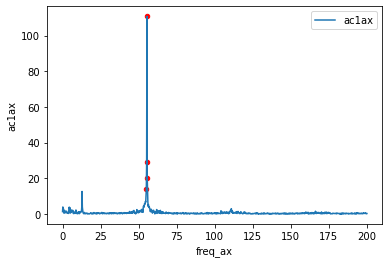

,freq_ax,ac1ax,harmonic
277,55.511,110.766,1.000
276,55.310,28.943,0.996
278,55.711,20.141,1.004
275,55.110,14.142,0.993


In [151]:
STUDY_FFT = signals_fft[['freq_ax','ac1ax']]

col_name = STUDY_FFT.columns[1]
ordered_study_fft = STUDY_FFT.sort_values(by=col_name, ascending=False) # ordenando o sinal
ordered_study_fft['n_harmonic'] = ordered_study_fft['freq_ax']/fundamental

pd.options.display.float_format = '{:,.3f}'.format


ax = signals_fft.iloc[:1000,:].plot(x='freq_ax', y=col_name)
ordered_study_fft.iloc[:4,:].plot(x='freq_ax', y=col_name, kind='scatter', color='red', ax=ax)
plt.show()

# mostra tabela
ordered_study_fft.iloc[:4,:]